In [49]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import json
import torch

from bnn_priors.exp_utils import load_samples

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Setup

In [50]:
exp_name = "201029_mnist_cnn"
use_eval_runs = True
exp_type = "mnist"

In [51]:
train_files = f"../results/{exp_name}/*/config.json"
eval_files = f"../results/{exp_name}/*/eval/*/config.json"

In [52]:
if use_eval_runs:
    files = eval_files
else:
    files = train_files

In [53]:
if exp_type == "mnist":
    calibration_data = "rotated_mnist"
    ood_data = "fashion_mnist"
elif exp_type == "cifar10":
    calibration_data = "cifar10c"
    ood_data = "svhn"
else:
    raise ValueError(f"Unknown experiment type {exp_type}")

In [54]:
# monolithic_priors = ["gaussian", "laplace", "student-t"] # ["gaussian", "laplace", "student-t", "cauchy", "improper", "gennorm"]
monolithic_priors = ["gaussian", "convcorrnormal", "improper", "datadrivencorrnormal"]
hierarchical_priors = ["gaussian_gamma", "laplace_gamma", "student-t_gamma", "horseshoe", "mixture",
                       "gaussian_empirical", "laplace_empirical", "student-t_empirical", "gennorm_empirical",
                      "scale_mixture", "scale_mixture_empirical"]

In [55]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None, x="weight_prior",
              title=None, baseline=None, plot_tempering=None, kind="bar"):
    assert plot_tempering is None or len(plot_tempering) == 2
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    if plot_tempering is not None:
        assert all([temp in temps for temp in plot_tempering])
        
    if 0. in temps:
        temps.remove(0.)
        
    if plot_tempering is None:
        fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(3*len(temps)+2,3*len(scales)+2))
    else:
        fig, axes = plt.subplots(len(scales), 2, sharex=True, figsize=(3*2+2,3*len(scales)+2))
    
    if len(scales) == 1:
        axes = [axes]

    if plot_tempering is None:
        for scale, axs in zip(scales, axes):
            if len(temps) == 1:
                axs = [axs]
            for temp, ax in zip(temps, axs):
                df = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
                df.plot(x=x, y=y, yerr=yerr, kind=kind, legend=False, ax=ax)
                ax.set_title(f"scale={scale} and T={temp}")
                ax.set_ylabel(ylabel)
                if ylim is not None:
                    ax.set_ylim(ylim)
                if baseline is not None:
                    ax.axhline(y=baseline, color="red", linestyle="dashed")
    else:
        for scale, axs in zip(scales, axes):
            df = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {plot_tempering[1]}")
            df.plot(x=x, y=y, yerr=yerr, kind=kind, legend=False, ax=axs[0])
            axs[0].set_title(f"scale={scale} and T={plot_tempering[1]}")
            axs[0].set_ylabel(ylabel)
            if ylim is not None:
                axs[0].set_ylim(ylim)
            if baseline is not None:
                axs[0].axhline(y=baseline, color="red", linestyle="dashed")
            df_tempered = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {plot_tempering[0]}")
            temp_diff = df_tempered.apply(lambda row: df.query(f"weight_prior == '{row['weight_prior']}'")[y].mean() - row[y], axis=1)
            df_tempered['temp_diff'] = temp_diff
            df_tempered.plot(x=x, y="temp_diff", kind=kind, legend=False, ax=axs[1])
            axs[1].set_title(f"scale={scale} tempering difference")
            axs[1].set_ylabel(f"$\Delta${ylabel}")
                
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()

    return fig

In [56]:
def plot_tempering_curve(runs, y, yerr=None, ylabel="performance", ylim=None, x="weight_prior",
              title=None, baseline=None, log_x=True):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    
    if 0. in temps:
        temps.remove(0.)
        
    
    fig, axes = plt.subplots(len(scales), 1, sharex=True, figsize=(3*2+2,3*len(scales)+2))
    
    if len(scales) == 1:
        axes = [axes]

    for scale, ax in zip(scales, axes):
        for x_val in runs.sort_values([x])[x].unique():
            df = runs.sort_values([x, "weight_scale", "temperature"]).query(f"weight_scale == {scale} & {x} == '{x_val}'")
            df.plot(x="temperature", y=y, yerr=yerr, kind="line", legend=True, ax=ax, label=x_val, linewidth=3)
            ax.set_title(f"scale={scale}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)
            if baseline is not None:
                ax.axhline(y=baseline, color="red", linestyle="dashed")
            if log_x:
                ax.set(xscale="log")
                
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()

    return fig

## Load results

In [57]:
runs = []
for config_file in glob(files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
    if not use_eval_runs and run_data["weight_prior"] == "improper":
        print(run_data["weight_prior"], run_data["temperature"], run_data["weight_scale"], config_file)
runs_all = pd.concat(runs, axis=1).T

In [58]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [59]:
runs_all.head()

,accuracy_eval,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,calibration_eval,config_file,...,lp_ensemble_std,lp_ensemble_stderr,lp_last,lp_mean,lp_std,lp_stderr,rmsce,auprc,auroc,error_mean
0,True,128,True,0,gaussian,{},1,10,True,../results/201029_mnist_cnn/21/config.json,...,1.80759,0.216049,-0.301397,-0.316808,0.0124502,0.00148809,0.00708256,NaN,NaN,0.233964
1,True,128,True,0,gaussian,{},1,10,False,../results/201029_mnist_cnn/21/config.json,...,-0.347032,-0.0414783,-2.42847,-2.47305,0.0427197,0.00510598,NaN,0.959401,0.95296,0.922834
2,True,128,True,0,gaussian,{},1,10,False,../results/201029_mnist_cnn/21/config.json,...,2.07308,0.247781,-0.04256,-0.0512179,0.00741178,0.000885877,NaN,NaN,NaN,0.0219043
3,True,128,True,0,gaussian,{},1,10,False,../results/201029_mnist_cnn/3/config.json,...,2.1081,0.251966,-0.0155624,-0.0161507,0.000483887,5.78355e-05,NaN,NaN,NaN,0.0103157
4,True,128,True,0,gaussian,{},1,10,True,../results/201029_mnist_cnn/3/config.json,...,1.8831,0.225073,-0.241748,-0.241152,0.00156518,0.000187075,0.0100463,NaN,NaN,0.201311


In [60]:
runs_all = runs_all[runs_all["acc_mean"].notnull()]

In [61]:
student_t_5_runs = runs_all.query("weight_prior == 'student-t'").apply(lambda row: "5" in str(row["weight_prior_params"]), axis=1)
runs_all = runs_all.drop(index=student_t_5_runs.where(student_t_5_runs == True).dropna().index)

## Evaluate predictive performance

In [62]:
if use_eval_runs:
    runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None
else:
    runs_selected = runs_all

In [63]:
acc_baseline = 1 - runs_selected.query("weight_prior == 'improper' & temperature == 0.")["acc_mean"].values[0]

In [64]:
lp_baseline = runs_selected.query("weight_prior == 'improper' & temperature == 0.")["lp_last"].values[0]

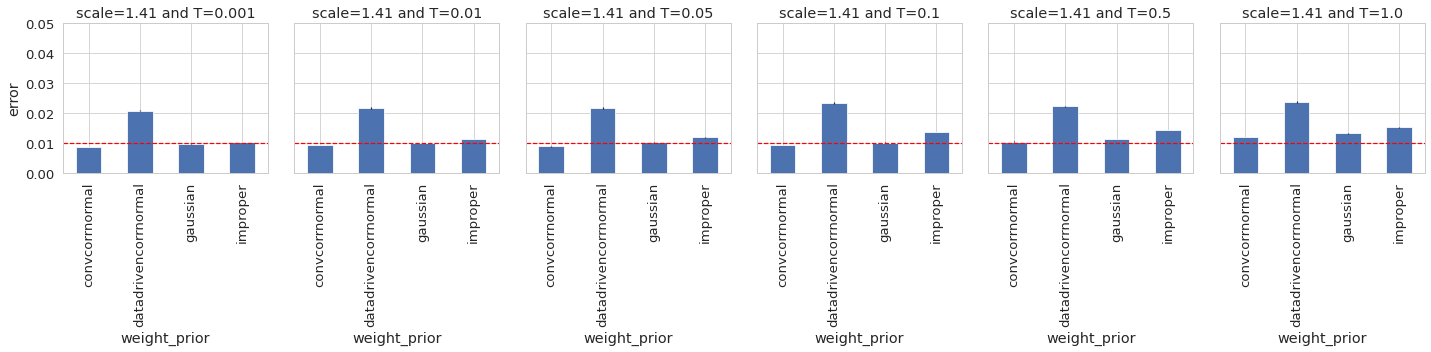

In [65]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.05), baseline=acc_baseline)

In [66]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

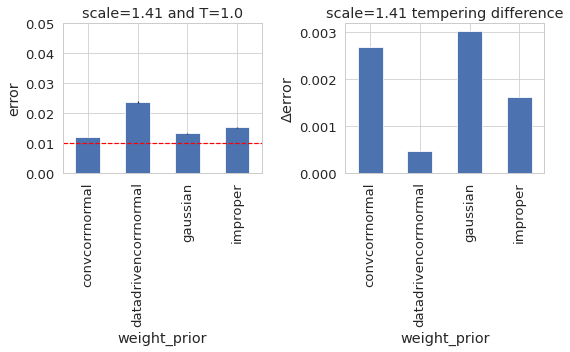

In [67]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.05), baseline=acc_baseline, plot_tempering=(0.1,1.))

In [68]:
fig.savefig(f"../figures/{exp_name}_acc_tempering.pdf")

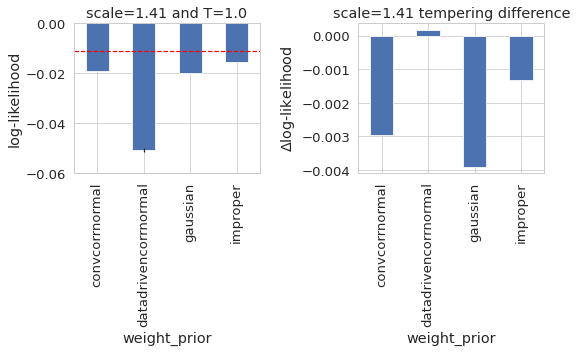

In [69]:
fig = plot_grid(runs_selected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.06, 0), baseline=lp_baseline, plot_tempering=(0.1,1.))

In [70]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [71]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

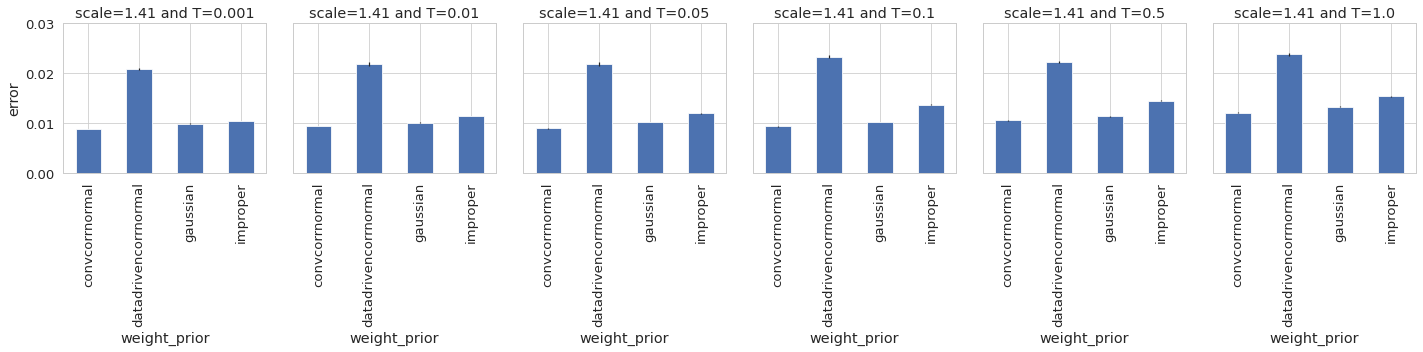

In [72]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.03))

In [73]:
fig.savefig(f"../figures/{exp_name}_acc_monolithic.pdf")

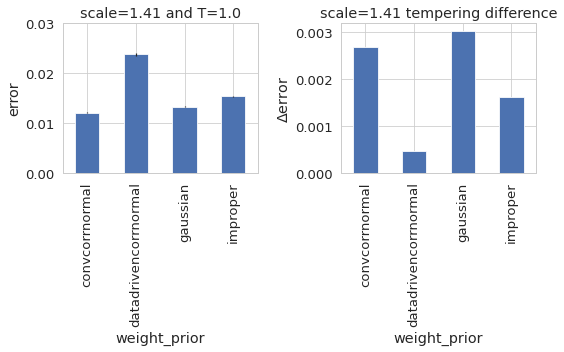

In [74]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.03), plot_tempering=(0.1,1.))

In [75]:
fig.savefig(f"../figures/{exp_name}_acc_monolithic_tempering.pdf")

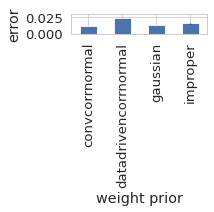

In [76]:
fig.axes[1].remove()
fig.axes[0].set_title("")
fig.axes[0].set_xlabel("weight prior")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_acc_monolithic_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

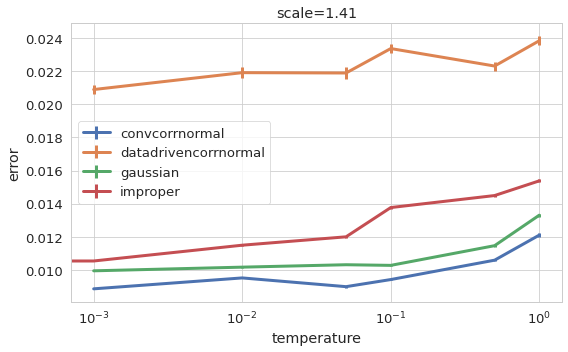

In [77]:
fig = plot_tempering_curve(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error")

In [78]:
fig.savefig(f"../figures/{exp_name}_acc_monolithic_tempering_curve.pdf")

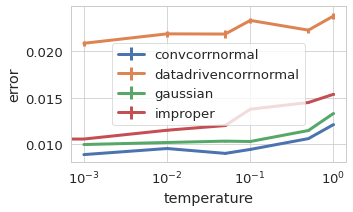

In [79]:
fig.axes[0].set_title("")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_acc_monolithic_tempering_curve_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

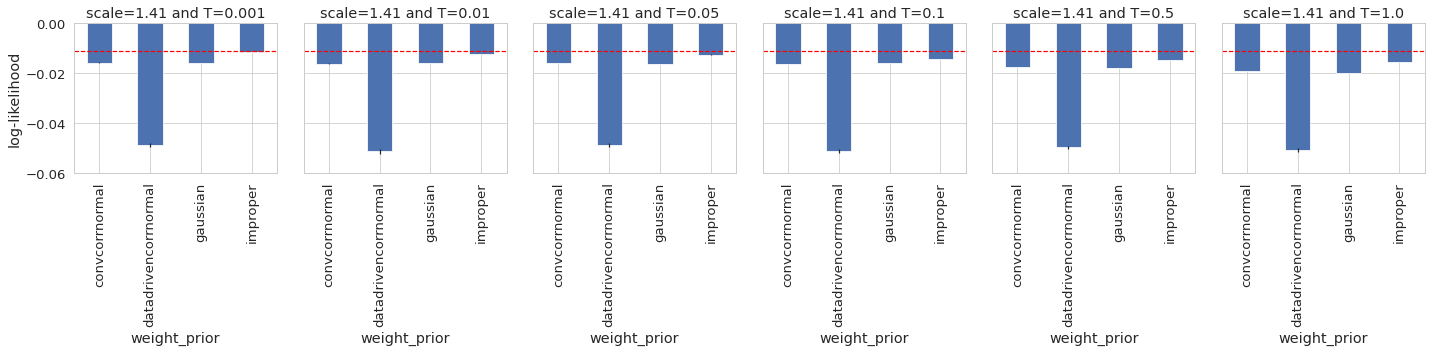

In [80]:
fig = plot_grid(runs_subselected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.06, 0), baseline=lp_baseline)

In [81]:
fig.savefig(f"../figures/{exp_name}_ll_monolithic.pdf")

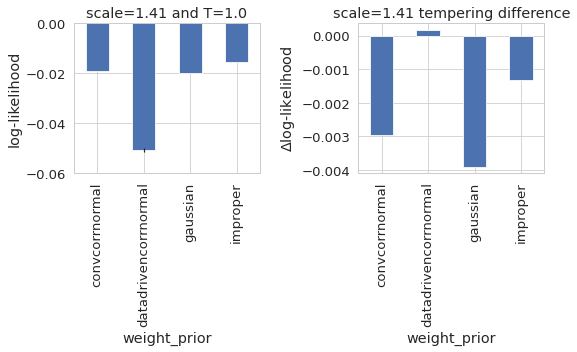

In [82]:
fig = plot_grid(runs_subselected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.06, 0), plot_tempering=(0.1,1.))

In [83]:
fig.savefig(f"../figures/{exp_name}_ll_monolithic_tempering.pdf")

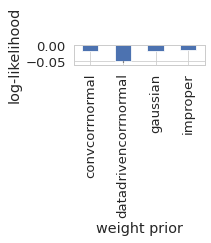

In [84]:
fig.axes[1].remove()
fig.axes[0].set_title("")
fig.axes[0].set_xlabel("weight prior")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_ll_monolithic_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

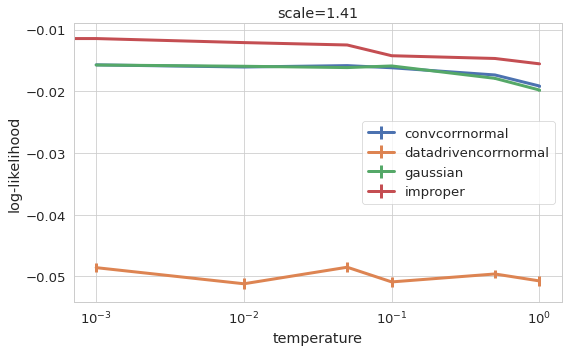

In [85]:
fig = plot_tempering_curve(runs_subselected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood")

In [86]:
fig.savefig(f"../figures/{exp_name}_ll_monolithic_tempering_curve.pdf")

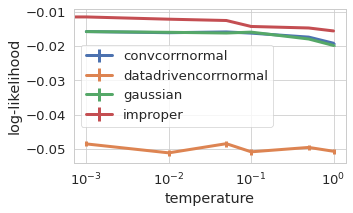

In [87]:
fig.axes[0].set_title("")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_ll_monolithic_tempering_curve_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

In [88]:
runs_subselected = runs_selected.query(f"weight_prior in {hierarchical_priors}")

In [89]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.03), baseline=acc_baseline)

<Figure size 144x144 with 0 Axes>

In [90]:
fig.savefig(f"../figures/{exp_name}_acc_hierarchical.pdf")

In [91]:
fig = plot_grid(runs_subselected, y="lp_ensemble", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.05, 0), baseline=lp_baseline)

<Figure size 144x144 with 0 Axes>

In [92]:
fig.savefig(f"../figures/{exp_name}_ll_hierarchical.pdf")

## Evaluate mixture models

In [34]:
skip = -50

df_mixture = pd.DataFrame(columns=["mixture", "weight_scale", "temperature", "layer", "component", "weight", "log_weight"])

for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "mixture":
        components = config["weight_prior_params"]["components"].split("_")
        samples_file = os.path.join(os.path.dirname(config_file),"samples.pt")
        if not os.path.exists(samples_file):
            continue
        samples = load_samples(samples_file)
        mixture_weights = {k[:5]:torch.nn.functional.softmax(v[skip:], dim=1).mean(0).detach().numpy()
                   for k, v in samples.items() if "mixture_weights" in k}
        scale = config['weight_scale']
        temp = config['temperature']
        for layer, weights in mixture_weights.items():
            for comp, weight in zip(components, weights):
                df_mixture.loc[len(df_mixture)] = [config["weight_prior_params"]["components"], scale, temp, layer, comp, weight, np.log(weight)]

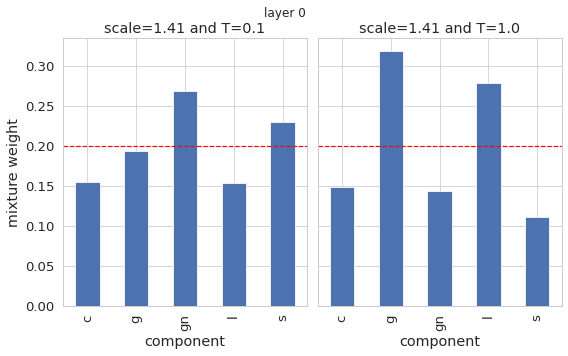

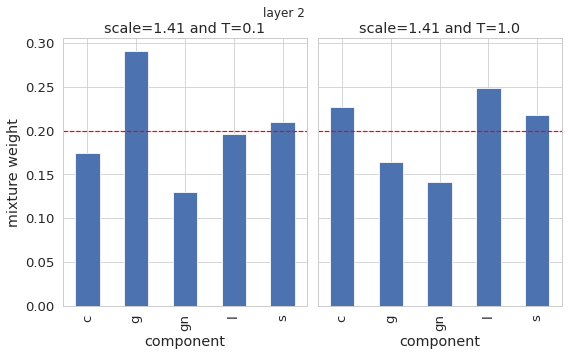

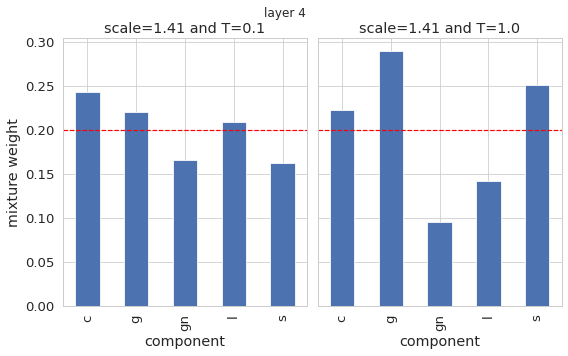

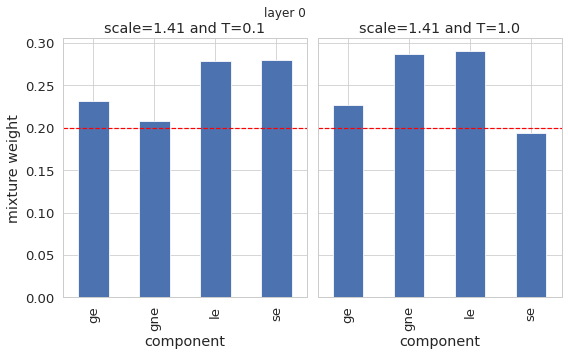

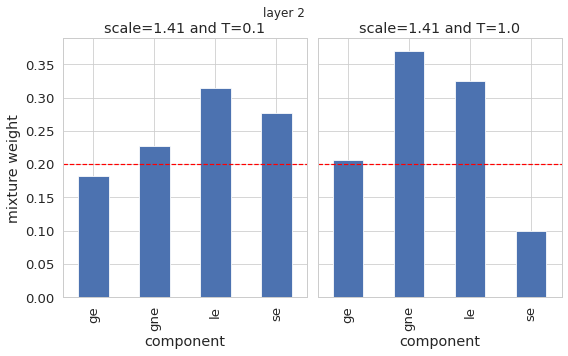

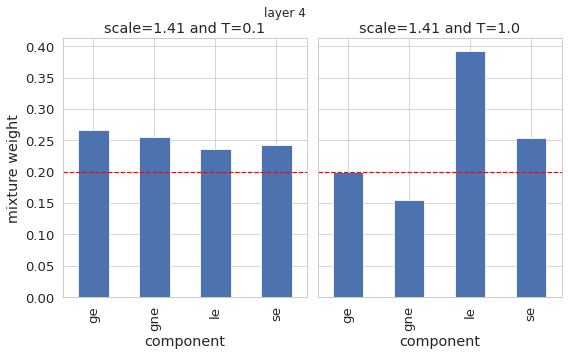

In [35]:
for mixture in df_mixture.mixture.unique():
    df_selected = df_mixture.query(f"mixture == '{mixture}'")
    with PdfPages(f"../figures/{exp_name}_mixture_{mixture}_weights.pdf") as pdf:
        for layer in df_selected.layer.unique():
            fig = plot_grid(df_selected.query(f"layer == '{layer}'"), y="weight", ylabel="mixture weight",
                            x="component", title=f"layer {int(layer.split('.')[-1])//2}", baseline=0.2)
            pdf.savefig()

## Evaluate marginal likelihood

In [36]:
assert use_eval_runs, "The marginal likelihood, calibration, and OOD can only be assessed on eval data"

In [37]:
runs_selected = runs_selected[runs_selected.weight_prior.apply(lambda val: val not in ["improper", "uniform", "mixture"])]

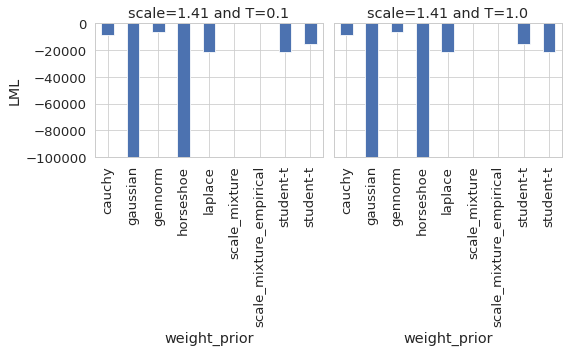

In [38]:
fig = plot_grid(runs_selected, y="simple_logmarglik", ylabel="LML", ylim=(-1e5, 0.))

In [39]:
fig.savefig(f"../figures/{exp_name}_logmargliks.pdf")

In [40]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

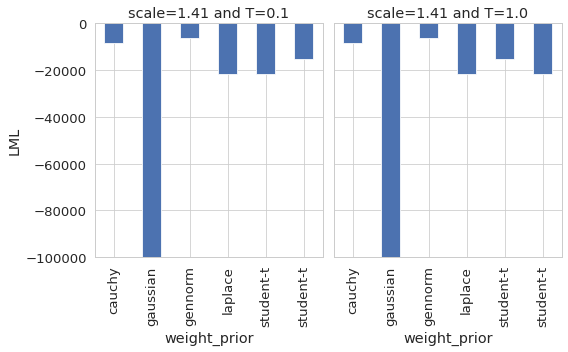

In [41]:
fig = plot_grid(runs_subselected, y="simple_logmarglik", ylabel="LML", ylim=(-1e5, 0.))

In [42]:
fig.savefig(f"../figures/{exp_name}_logmargliks_monolithic.pdf")

In [43]:
# margliks = runs_selected["simple_logmarglik"].values.astype(float)
# lls = runs_selected["lp_mean"].values.astype(float)
# accs = runs_selected["acc_mean"].values.astype(float)

In [44]:
# print("Correlation between log marginal likelihoods and test log likelihoods:")
# print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
# print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
# print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

# print("Correlation between log marginal likelihoods and test errors:")
# print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
# print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
# print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))

In [45]:
# priors = runs_selected.weight_prior.unique()
# for prior in priors:
#     print(f"Testing {prior} prior")

#     runs_subselected = runs_selected.query(f"weight_prior == '{prior}'")
#     margliks = runs_subselected["simple_logmarglik"].values.astype(float)
#     lls = runs_subselected["lp_mean"].values.astype(float)
#     accs = runs_subselected["acc_mean"].values.astype(float)

#     print("Correlation between log marginal likelihoods and test log likelihoods:")
#     print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
#     print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
#     print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

#     print("Correlation between log marginal likelihoods and test errors:")
#     print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
#     print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
#     print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))
#     print("")

## Evaluate calibration

In [93]:
runs_selected = runs_all.query(f"'{calibration_data}' in eval_data")

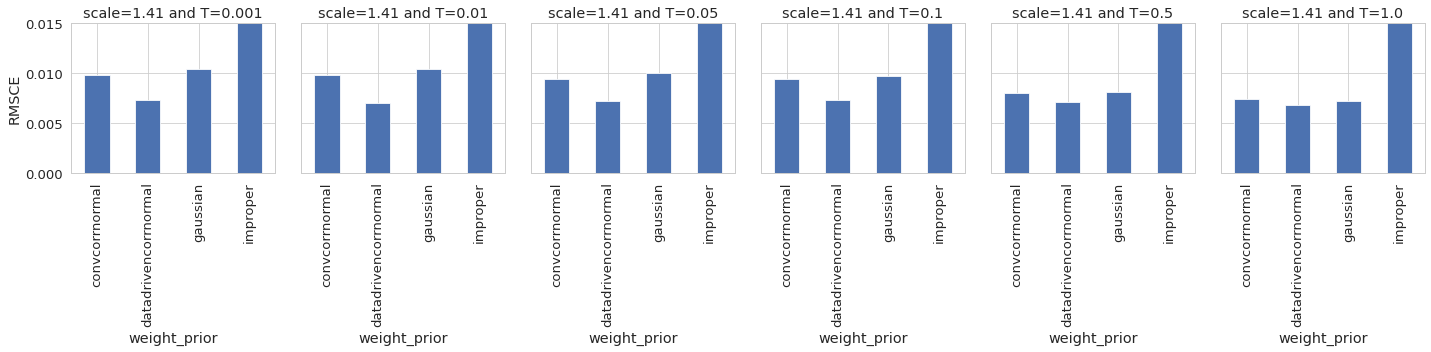

In [94]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [95]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

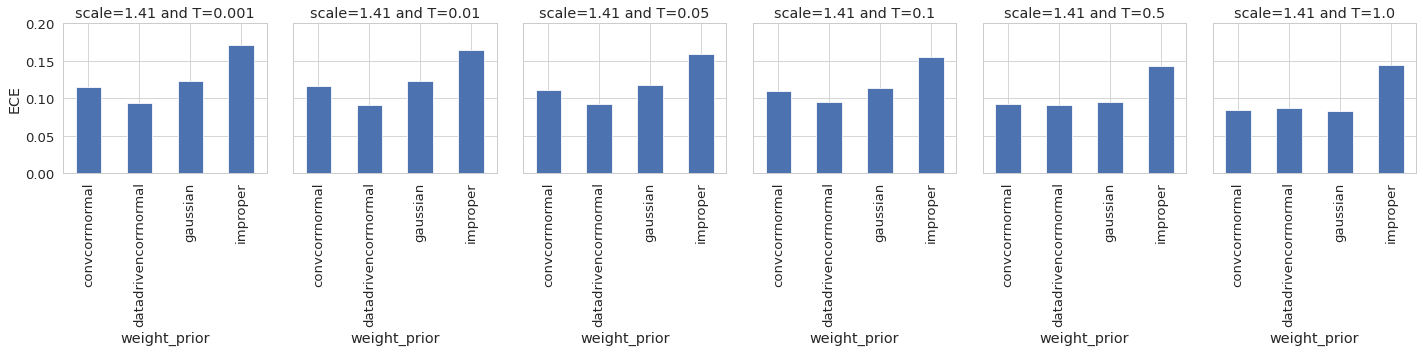

In [96]:
fig = plot_grid(runs_selected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [97]:
fig.savefig(f"../figures/{exp_name}_ece.pdf")

In [98]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

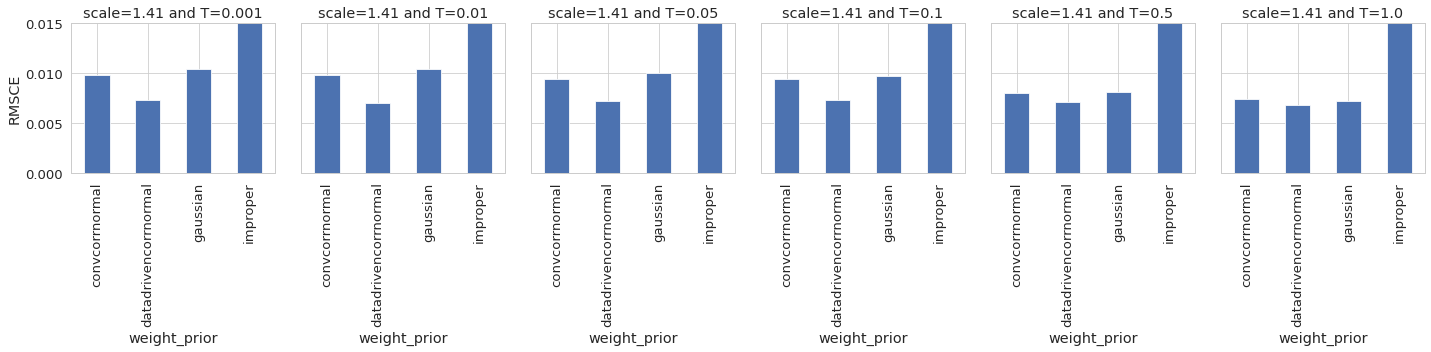

In [99]:
fig = plot_grid(runs_subselected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [100]:
fig.savefig(f"../figures/{exp_name}_rmsce_monolithic.pdf")

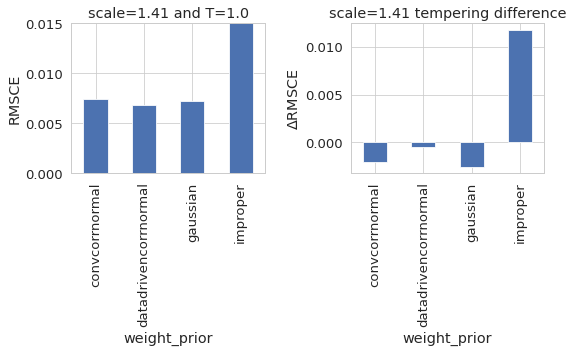

In [101]:
fig = plot_grid(runs_subselected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015), plot_tempering=(0.1,1.))

In [102]:
fig.savefig(f"../figures/{exp_name}_rmsce_monolithic_tempering.pdf")

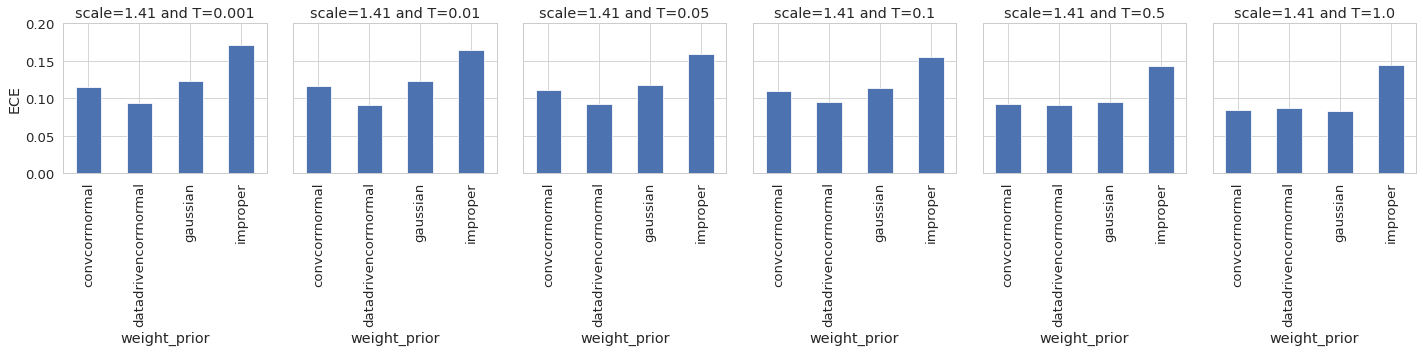

In [103]:
fig = plot_grid(runs_subselected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [104]:
fig.savefig(f"../figures/{exp_name}_ece_monolithic.pdf")

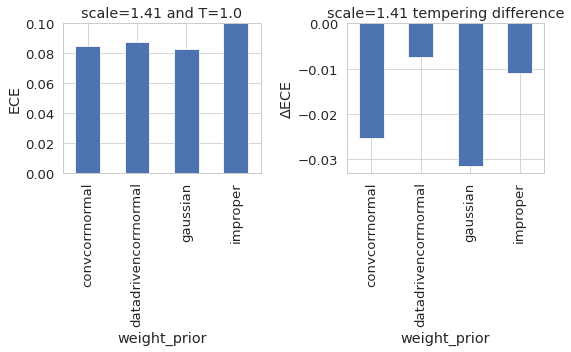

In [105]:
fig = plot_grid(runs_subselected, y="ece", ylabel="ECE", ylim=(0, 0.1), plot_tempering=(0.1,1.))

In [106]:
fig.savefig(f"../figures/{exp_name}_ece_monolithic_tempering.pdf")

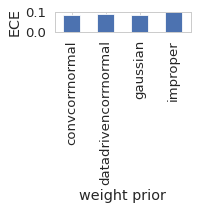

In [107]:
fig.axes[1].remove()
fig.axes[0].set_title("")
fig.axes[0].set_xlabel("weight prior")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_ece_monolithic_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

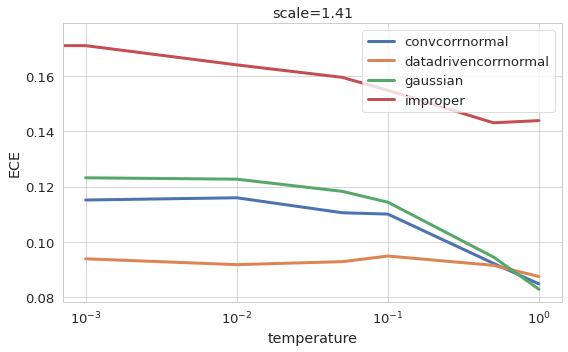

In [108]:
fig = plot_tempering_curve(runs_subselected, y="ece", ylabel="ECE")

In [109]:
fig.savefig(f"../figures/{exp_name}_ece_monolithic_tempering_curve.pdf")

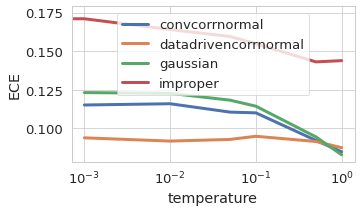

In [110]:
fig.axes[0].set_title("")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_ece_monolithic_tempering_curve_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

## Evaluate OOD detection

In [111]:
runs_selected = runs_all.query(f"'{ood_data}' in eval_data")

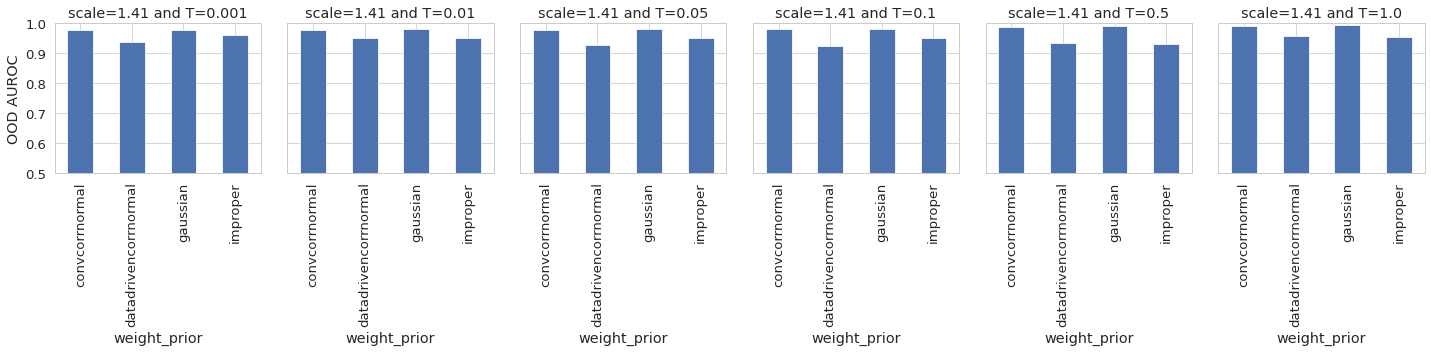

In [112]:
fig = plot_grid(runs_selected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [113]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

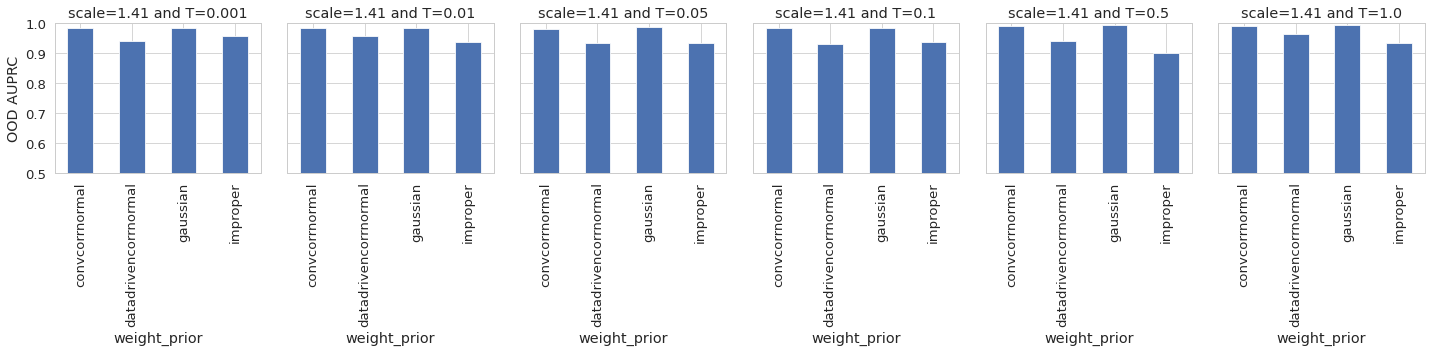

In [114]:
fig = plot_grid(runs_selected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [115]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

In [116]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

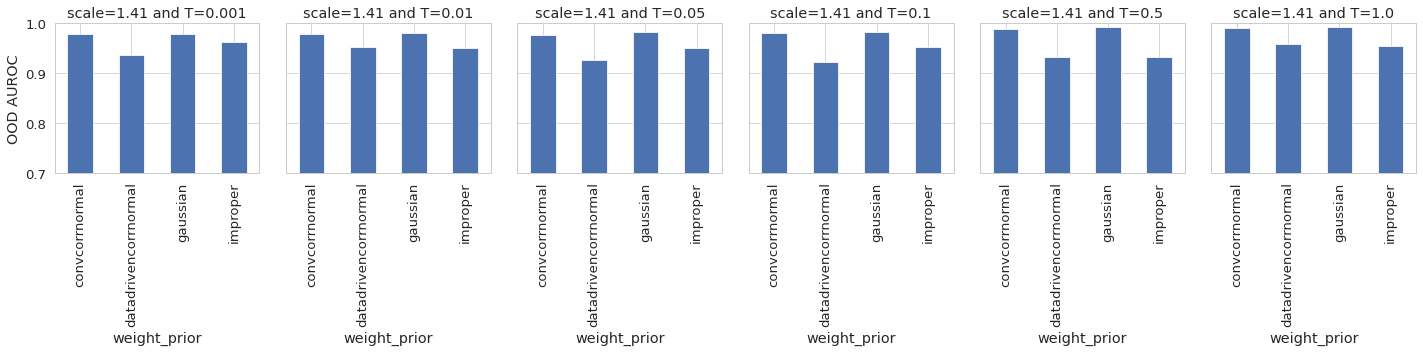

In [117]:
fig = plot_grid(runs_subselected, y="auroc", ylabel="OOD AUROC", ylim=(0.7, 1.))

In [118]:
fig.savefig(f"../figures/{exp_name}_ood_auroc_monolithic.pdf")

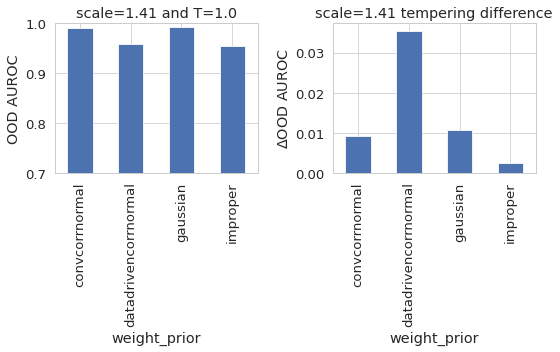

In [119]:
fig = plot_grid(runs_subselected, y="auroc", ylabel="OOD AUROC", ylim=(0.7, 1.), plot_tempering=(0.1,1.))

In [120]:
fig.savefig(f"../figures/{exp_name}_ood_auroc_monolithic_tempering.pdf")

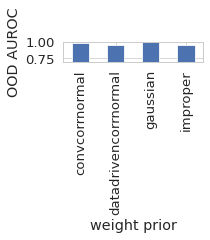

In [121]:
fig.axes[1].remove()
fig.axes[0].set_title("")
fig.axes[0].set_xlabel("weight prior")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_ood_monolithic_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

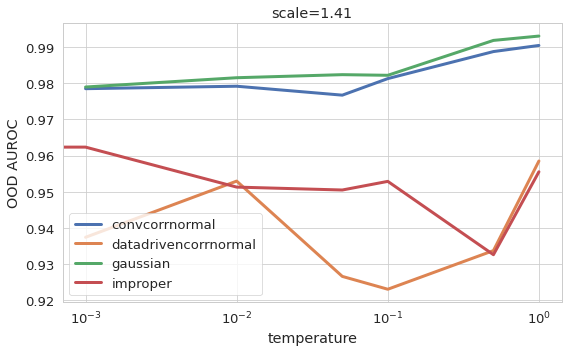

In [122]:
fig = plot_tempering_curve(runs_subselected, y="auroc", ylabel="OOD AUROC")

In [123]:
fig.savefig(f"../figures/{exp_name}_ood_auroc_monolithic_tempering_curve.pdf")

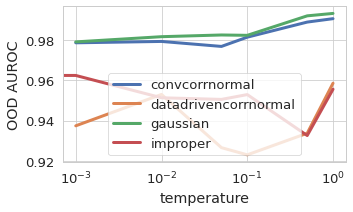

In [124]:
fig.axes[0].set_title("")
fig.set_size_inches(5,3)
fig.tight_layout()
fig.savefig(f"../figures/{exp_name}_ood_auroc_monolithic_tempering_curve_small.pdf", bbox_inches = 'tight', pad_inches = 0.1)
fig

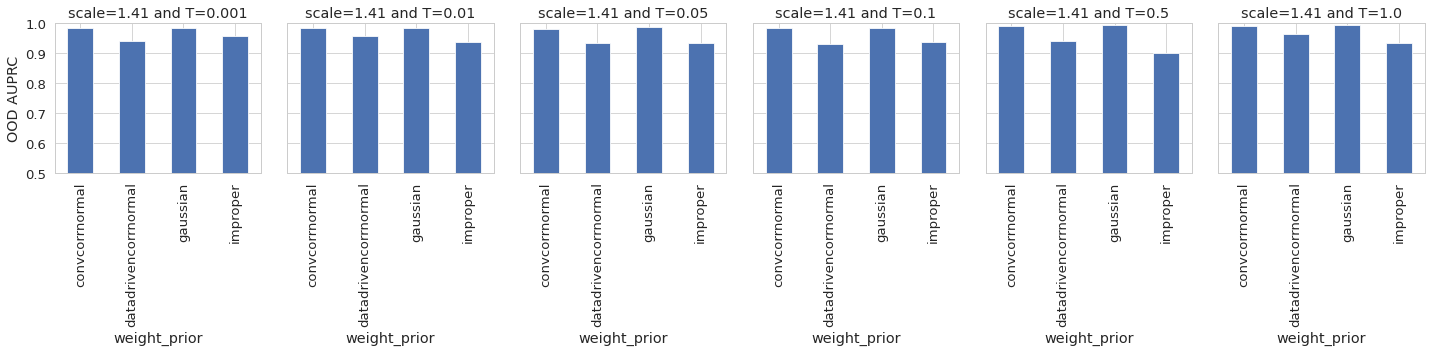

In [125]:
fig = plot_grid(runs_subselected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [126]:
fig.savefig(f"../figures/{exp_name}_ood_auprc_monolithic.pdf")

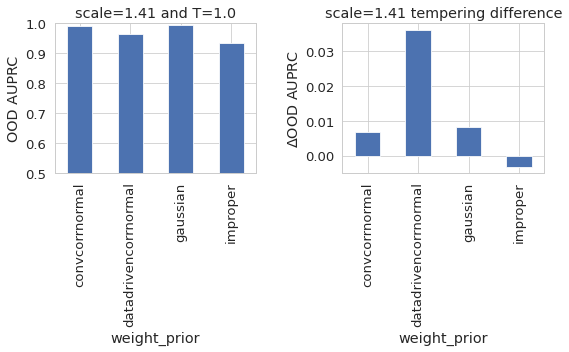

In [127]:
fig = plot_grid(runs_subselected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.), plot_tempering=(0.1,1.))

In [128]:
fig.savefig(f"../figures/{exp_name}_ood_auprc_monolithic_tempering.pdf")

## Evaluate empirical distribution of weights

In [9]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm
from sklearn.mixture import GaussianMixture

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,st.norm,st.t]
    DISTRIBUTIONS = [st.laplace,st.norm,st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)


def make_pdf(dist, params, size=1000, start=None, end=None):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    if start is None:
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    if end is None:
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [10]:
final_weights = None
for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "improper":
        samples = load_samples(os.path.join(os.path.dirname(config_file),"samples.pt"))
        final_weights_sample = {param : val[-1] for param, val in samples.items() if "weight_prior.p" in param}
        if final_weights is None:
            final_weights = final_weights_sample
        else:
            final_weights = {param: torch.cat((final_weights[param], val)) for param, val in final_weights_sample.items()}
final_weights = {param: val.detach().numpy().flatten() for param, val in final_weights.items()}

net.0.weight_prior.p t (1.478411495562297, 0.0009041260220786986, 0.1499258503368181)
net.2.weight_prior.p t (8.239139016817365, 0.01037136138572272, 0.23851624878504316)
net.4.weight_prior.p t (18.148443042235122, 0.0022099386541083134, 0.3004424725316495)


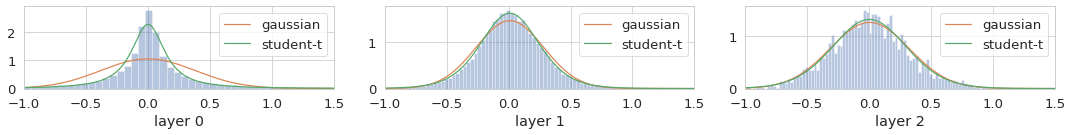

In [11]:
xlim = (-1, 1.5)
layer_fits = {}
fig, axs = plt.subplots(ncols=len(final_weights), figsize=(5*len(final_weights), 2))
for i, ((param, weights), ax) in enumerate(zip(final_weights.items(), axs)):
    sns.distplot(weights, ax=ax, bins=100, kde=False, norm_hist=True)
    ax.set_xlabel(f"layer {i}")
    ax.set_xlim(xlim)
    best_fit_name, best_fit_params, sses = best_fit_distribution(weights, 200)
    if best_fit_name == "t":
        best_fit_label = "student-t"
    elif best_fit_name == "norm":
        best_fit_name = "t"
        best_fit_label = "student-t"
    else:
        best_fit_label = best_fit_name
    print(param, best_fit_name, best_fit_params)
    layer_fits[param] = {k: v for i, (k, v) in enumerate(sorted(sses.items(), key=lambda item: item[1])) if i<5}
    fit_dist = getattr(stats, best_fit_name)
    fit_pdf = make_pdf(fit_dist, fit_dist.fit(weights), start=xlim[0], end=xlim[1])
    gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weights), start=xlim[0], end=xlim[1])
    sns.lineplot(data=gauss_pdf, label="gaussian", ax=ax)
    sns.lineplot(data=fit_pdf, label=best_fit_label, ax=ax)
fig.tight_layout()

In [12]:
fig.savefig(f"../figures/{exp_name}_empirical_weightdist.pdf")

In [78]:
for param, fits in layer_fits.items():
    print(f"Best fit for {param} weigths: ",", ".join([f"{dist} ({err:.2f})" for dist, err in fits.items()]))

Best fit for net.1.weight_prior.p weigths:  norm (3.92), t (3.92), laplace (5.06)
Best fit for net.4.weight_prior.p weigths:  t (1.12), norm (1.98), laplace (3.84)
Best fit for net.8.weight_prior.p weigths:  t (0.67), laplace (1.13), norm (13.25)


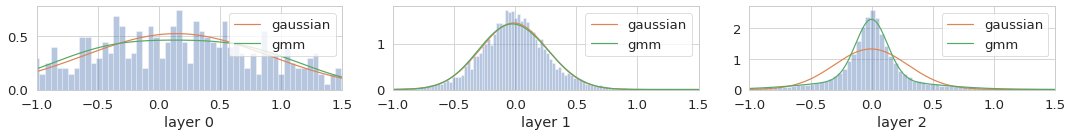

In [79]:
xlim = (-1., 1.5)
layer_fits = {}
fig, axs = plt.subplots(ncols=len(final_weights), figsize=(5*len(final_weights), 2))
for i, ((param, weights), ax) in enumerate(zip(final_weights.items(), axs)):
    sns.distplot(weights, ax=ax, bins=100, kde=False, norm_hist=True)
    ax.set_xlabel(f"layer {i}")
    ax.set_xlim(xlim)
    gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weights), start=xlim[0], end=xlim[1])
    sns.lineplot(data=gauss_pdf, label="gaussian", ax=ax)
    gm = GaussianMixture(2)
    gm.fit(weights.reshape([-1,1]))
    linspace_x = np.linspace(*xlim, 1000)
    gmm_pdf = np.exp(gm.score_samples(linspace_x.reshape([-1,1])))
    sns.lineplot(x=linspace_x, y=gmm_pdf, label="gmm", ax=ax)
fig.tight_layout()

In [80]:
fig.savefig(f"../figures/{exp_name}_gmm_weightdist.pdf")

In [81]:
for param, weight in final_weights.items():
    print(f"Normality tests for {param}:")
    print(f"Mean = {weight.mean():.2f}, std = {weight.flatten().std():.2f}")
    print("D'Angostino: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.normaltest(weight)))
    print("Shapiro: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.shapiro(np.random.choice(weight, size=min(5000, len(weight)), replace=False))))
    print("")
    gm = GaussianMixture(2)
    gm.fit(weight.reshape([-1,1]))
    print("\n".join([f"weight = {w:.2f}, mean = {m:.2f}, std = {np.sqrt(v):.3f}" for w,m,v in zip(gm.weights_, gm.means_.flatten(), gm.covariances_.flatten())]))
    print("")

Normality tests for net.1.weight_prior.p:
Mean = 0.14, std = 0.76
D'Angostino: statistic = 2.60, p-value = 2.73e-01
Shapiro: statistic = 1.00, p-value = 7.04e-01

weight = 0.52, mean = -0.35, std = 0.558
weight = 0.48, mean = 0.69, std = 0.549

Normality tests for net.4.weight_prior.p:
Mean = -0.01, std = 0.28
D'Angostino: statistic = 93.40, p-value = 5.22e-21
Shapiro: statistic = 1.00, p-value = 5.28e-12

weight = 0.51, mean = -0.14, std = 0.239
weight = 0.49, mean = 0.12, std = 0.250

Normality tests for net.8.weight_prior.p:
Mean = -0.00, std = 0.30
D'Angostino: statistic = 1997.46, p-value = 0.00e+00
Shapiro: statistic = 0.93, p-value = 1.50e-43

weight = 0.68, mean = -0.00, std = 0.135
weight = 0.32, mean = -0.01, std = 0.493

